# Домашнее задание 5. Линейные модели

In [1]:
# Plotting config
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Зачитываем результат 4 домашки

In [2]:
data = np.load("out_4.dat.npz")
users = data["users"]
X = data["data"].reshape(1,)[0]

Зачитываем категории пользователей

In [3]:
TRAINING_SET_URL = "../twitter_train.csv"
df_users = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["twitter_id", "is_1", "is_2", "is_3"], dtype={"twitter_id": str, "is_1": int, 'is_2': int, "is_3": int})
df_users.set_index("twitter_id", inplace=True)

Формируем целевую переменную: Делаем join списка пользователей из ДЗ4 с обучающей выборкой.

In [4]:
def f(x):
    if x[0] == 1:
        return 1
    if x[1] == 1:
        return 2
    if x[2] == 1:
        return 3

Y = df_users[['is_1', 'is_2', 'is_3']].apply(f, axis=1).values
print "Resulting training set: (%dx%d) feature matrix, %d target vector" % (X.shape[0], X.shape[1], Y.shape[0])

Resulting training set: (3000x125399) feature matrix, 3000 target vector


Чтобы исследовать, как ведут себя признаки, построим распределение количества ненулевых признаков у пользователей, чтобы убедиться, что он удовлетворяет закону Ципфа. Для этого построим гистограмму в логарифмических осях. [Подсказка](http://anokhin.github.io/img/sf1.png)

/home/ospanoff/.pyenv/versions/python2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


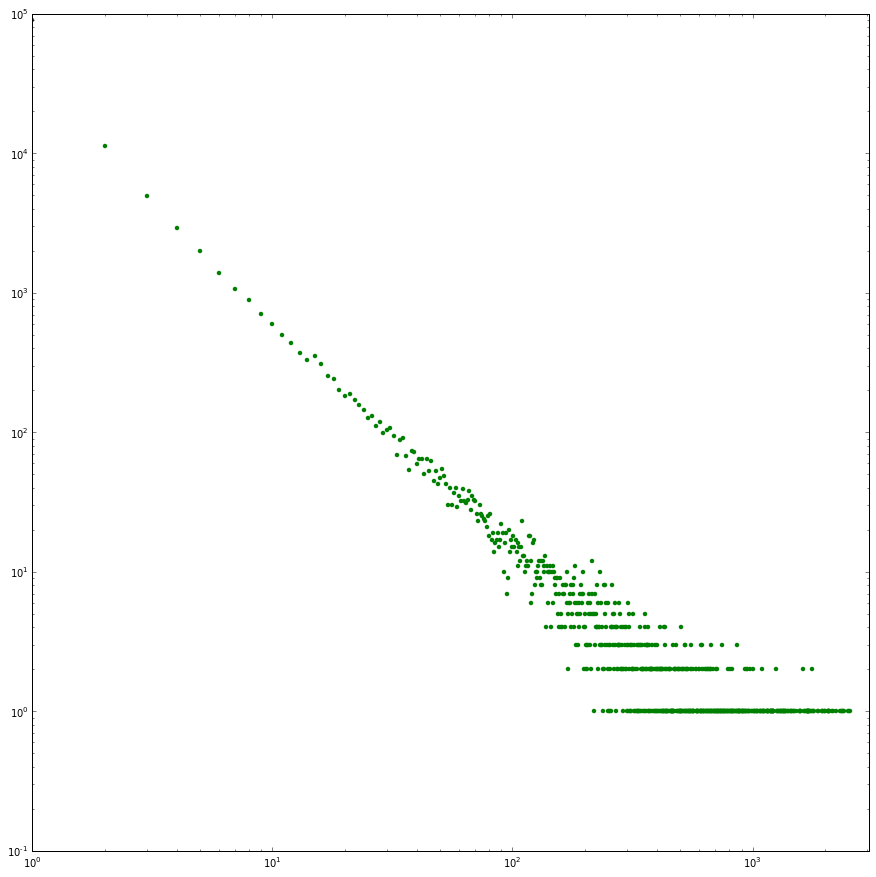

In [5]:
def draw_log_hist(X):
    """Draw tokens histogram in log scales"""
    features_counts = np.asarray((X > 0).sum(axis=0)).ravel()
    tmp_x, tmp_y = np.unique(features_counts, return_counts=True)

    plt.figure(figsize=(15, 15))
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim((tmp_x.min(), tmp_x.max() * 1.2))
    plt.scatter(tmp_x, tmp_y, c='g', linewidths=0)
    plt.show()
    plt.show()
    
    return features_counts.astype(np.int)

features_counts = draw_log_hist(X)

Проведем отбор признаков. В самом простом случае просто удаляем признаки, имеющие ненулевое значение у менее, чем 100 пользователей.

In [6]:
X1 = X.tocsc()[:, features_counts > 100].toarray()

Вариант задания генерируется на основании вашего ника в техносфере.

In [7]:
USER_NAME = "a.ospanov"
OPTIMIZATION_ALGORITHMS = ["stochastic gradient descent", "Newton method"]
REGULARIZATIONS = ["L1", "L2"]

print "My homework 5 algorithm is: Logistic regression with %s regularization optimized by %s" % (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    OPTIMIZATION_ALGORITHMS[hash(USER_NAME[::-1]) % 2]
)

My homework 5 algorithm is: Logistic regression with L1 regularization optimized by stochastic gradient descent


Реализуем выбранный алгоритм

In [8]:
import sys

In [9]:
class LogisticRegression():
    def __init__(self, C=1.0, max_iter=300, beta=0.5, eps=0.001):
        self.C = C
        self.max_iter = max_iter
        self.beta = beta # for eta: eta = i ** (-beta)
        self.eps = eps
        

    def sigmoid(self, z):
        """
        Return Sigmoid of z
        Args:
            z : ndarray or scalar
        """
        return 1.0 / (1.0 + np.exp(-z))


    def fit(self, X, Y):
        """
        Args:
            X : ndarray (M x N)
            Y : ndarray (M x 1)
        """
        if Y.ndim == 1:
            Y = Y[:, np.newaxis]
            
        X = np.hstack((np.ones((X.shape[0], 1)), X))

        self.theta = np.zeros((X.shape[1], 1))
#         self.theta = np.random.rand(X.shape[1], 1)

        it = 1
        while True:
            h = self.sigmoid(X.dot(self.theta)) - Y
            grad = (h.T.dot(X) + self.C).T / X.shape[0]
            grad[0] = np.mean(h)

            eta = it ** (-self.beta)
            self.theta -= eta * grad
#             sys.stdout.write("\r%d, %f" % (it, np.sum(np.abs(eta * grad))))
#             sys.stdout.flush()
            it += 1
            if np.all(np.abs(eta * grad) < self.eps) or it > self.max_iter:
                break
                
        return self

    
    def predict_proba(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        return self.sigmoid(X.dot(self.theta))
    
    
    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(np.int)

In [10]:
class LogisticRegressionMulticlass():
    def __init__(self, C=1.0, max_iter=300, beta=0.5, eps=0.001, multi_class='ovr'):
        self.C = C
        self.max_iter = max_iter
        self.beta = beta # for eta: eta = i ** (-beta)
        self.eps = eps
        self.multi_class = multi_class


    def fit(self, X, Y):
        """
        Args:
            X : ndarray (M x N)
            Y : ndarray (M x 1)
        """
        if Y.ndim == 1:
            Y = Y[:, np.newaxis]
        
        self.ys = np.unique(Y)
        self.clfrs = [LogisticRegression(C=self.C, max_iter=self.max_iter,
                                    beta=self.beta, eps=self.eps) for i in self.ys]
        
        for i, y in enumerate(self.ys):
            y_bin = np.zeros(Y.shape)
            y_bin[np.where(Y == y)] = 1
            self.clfrs[i].fit(X, y_bin)
                
        return self

    
    def predict_proba(self, X):
        ans = np.zeros((X.shape[0], len(self.ys)))
        for i in xrange(len(self.ys)):
            ans[:, i] = self.clfrs[i].predict_proba(X).ravel()
            
        return ans / ans.sum(axis=1)[:, np.newaxis]

    
    def predict(self, X):
        return self.ys[np.argmax(self.predict_proba(X), axis=1)]

### Тест классификаторов

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression as LG

#### Двухклассовый случай

In [12]:
ind = np.append(np.where(Y == 1)[0], np.where(Y == 3)[0]) # выбраны классы 1 и 3, т.к. распределены одинаково
Y1 = (Y[ind] - 1) / 2

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X1[ind], Y1, test_size=0.33)

In [14]:
lg = LogisticRegression()
%time lg.fit(x_train, y_train)

CPU times: user 2.5 s, sys: 996 µs, total: 2.5 s
Wall time: 2.5 s


<__main__.LogisticRegression instance at 0x7f3e8b3c9248>

In [15]:
accuracy_score(y_test, lg.predict(x_test))

0.68028846153846156

sklearn-ский классификатор

In [16]:
lg_sk = LG(max_iter=300)
%time lg_sk.fit(x_train, y_train)

CPU times: user 604 ms, sys: 0 ns, total: 604 ms
Wall time: 686 ms


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=300, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [17]:
accuracy_score(y_test, lg_sk.predict(x_test))

0.66947115384615385

#### Многоклассовый случай

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X1, Y, test_size=0.33)

In [19]:
lgm = LogisticRegressionMulticlass()
%time lgm.fit(x_train, y_train)

CPU times: user 11.8 s, sys: 38.5 ms, total: 11.8 s
Wall time: 11.8 s


<__main__.LogisticRegressionMulticlass instance at 0x7f3e8b3d1200>

In [20]:
accuracy_score(y_test, lgm.predict(x_test))

0.56262626262626259

sklearn-ский классификатор

In [21]:
%time lg_sk.fit(x_train, y_train)

CPU times: user 2.62 s, sys: 3.87 ms, total: 2.63 s
Wall time: 2.63 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=300, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [22]:
accuracy_score(y_test, lg_sk.predict(x_test))

0.52727272727272723

<br>

Реализуем метрику качества, используемую в соревновании: площадь под ROC кривой

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve

In [24]:
from sklearn.cross_validation import KFold

In [25]:
def auroc(y_true, y_prob):
    ys = np.unique(y_true)
    y_pred = ys[np.argmax(y_prob, axis=1)]
    score = np.empty(ys.size)
    for i, y in enumerate(ys):
        y_bin, y_bin_p = np.zeros(y_true.shape), np.zeros(y_true.shape)
        y_bin[np.where(y_true == y)] = 1
        y_bin_p[np.where(y_pred == y)] = 1
        score[i] = roc_auc_score(y_bin, y_bin_p)
        
    return score.tolist()

Разделим выборку с помощью методики кросс-валидации для того, чтобы настроить параметр регуляризации $C$

In [26]:
C = [0.0, 0.01, 0.1, 1, 10, 100, 1000, 10000]

def select_reg_parameter(C, X, Y, n_folds=3):
    max_score = 0
    auc = []
    folds = KFold(X.shape[0], n_folds)
    for c in C:
        clf = LogisticRegressionMulticlass(C=c)
        for tr_i, te_i in folds:
            clf.fit(X[tr_i], Y[tr_i])
            auc.append(auroc(Y[te_i], clf.predict_proba(X[te_i])))
            
        score = np.median(auc, axis=0)
        if np.all(score > 0.5) and score.sum() > max_score:
            max_score = score.sum()
            best_C = c

        auc = []
            
    return C.index(best_C)
        

%time index = select_reg_parameter(C, X1, Y)
print index

CPU times: user 4min 6s, sys: 87.5 ms, total: 4min 7s
Wall time: 4min 6s
3


Выбираем наилучшее значение $C$, и классифицируем неизвестных пользователей и строим ROC-кривую

CPU times: user 10.4 s, sys: 8.01 ms, total: 10.4 s
Wall time: 10.4 s


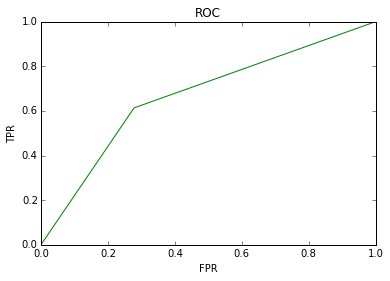

Area under the ROC curve : 0.667619


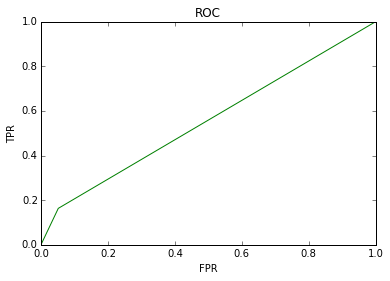

Area under the ROC curve : 0.555736


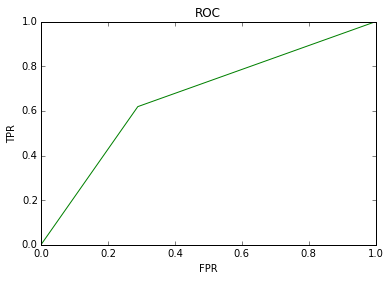

Area under the ROC curve : 0.664888


In [27]:
def predict(X, Y, test_size, C):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)
    clf = LogisticRegressionMulticlass()
    clf.fit(x_train, y_train)
    y_prob = clf.predict_proba(x_test)

    return y_test, y_prob


def roc(Y_test, Y_prob, y_prob_ind, pos_label):
    y_bin = np.zeros(Y_test.size)
    y_bin[Y_test == pos_label] = 1
    y_bin_p = 1 * (Y_prob[:, y_prob_ind] > 0.5)
    fpr, tpr, _ = roc_curve(y_bin, y_bin_p)
    roc_auc = roc_auc_score(y_bin, y_bin_p)
    
    return tpr, fpr, roc_auc


def plot_roc_curve(tpr, fpr, roc_auc):
    """Plot ROC curve"""
    plt.title("ROC")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr, tpr, c='g')
    plt.show()


%time Y_test, Y_prob = predict(X1, Y, 0.3, C[index])

tpr, fpr, roc_auc = roc(Y_test, Y_prob, 0, 1)
plot_roc_curve(tpr, fpr, roc_auc)
print "Area under the ROC curve : %f" % roc_auc

tpr, fpr, roc_auc = roc(Y_test, Y_prob, 1, 2)
plot_roc_curve(tpr, fpr, roc_auc)
print "Area under the ROC curve : %f" % roc_auc

tpr, fpr, roc_auc = roc(Y_test, Y_prob, 2, 3)
plot_roc_curve(tpr, fpr, roc_auc)
print "Area under the ROC curve : %f" % roc_auc

С помощью полученной модели предсказываем категории для неизвестных пользователей из соревнования и загружаем на kaggle в нужном формате.